In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.colors as colors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import scipy.signal as sg
import scipy.ndimage as img
import gsw_xarray as gsw

from functions.latex import set_size
from skimage import measure
from cartopy.util import add_cyclic_point

datadir = "../data/"
figdir = "../figures/"

In [2]:
def get_region_coords(region_name="arctic_ocean", xy=False):
    region_dict = {
        "arctic_ocean": {False: [-180, 180, 60, 90], True: [65, 185, 0, 215]},
        "canada_basin": {False: [-180, -95, 70, 85], True: [70, 130, 135, 205]},
        "amerasian_basin": {False: [], True: [70, 160, 120, 205]},
        "eurasian_basin": {False: [-180, 180, 78, 90], True: [110, 180, 80, 170]},
        "makarov_basin": {False: [-180, 180, 78, 90], True: [110, 155, 120, 190]},
        "greenland_basin": {False: [-15, 15, 72, 80], True: [110, 145, 50, 85]},
        "lofoten_basin": {False: [-5, 13.5, 68, 73], True: [125, 145, 30, 55]},
        "norwegian_basin": {False: [-8, 3, 63, 71], True: [115, 135, 15, 45]},
        "norwegian_seas": {False: [-15, 15, 62, 73], True: [115, 155, 10, 55]},
        "nordic_seas": {False: [-15, 15, 62, 73], True: [75, 175, 0, 90]},
    }
    
    if region_name not in region_dict:
        raise ValueError("Undefined region, please check spelling.")
    
    return region_dict[region_name][xy]

def create_map(region, subplots=(1, 1), **kwargs):
    #if region_name == "arctic_mediterranean":
    if (region[0] + region[1] == 0) and region[-1] == 90:
        proj = ccrs.NorthPolarStereo()
        theta = np.linspace(0, 2*np.pi, 100)
        center, radius = [0.5, 0.5], 0.5
        verts = np.vstack([np.sin(theta), np.cos(theta)]).T
        shape = mpath.Path(verts * radius + center)
    else:
        proj = ccrs.LambertConformal(central_longitude=(region[0] + region[1])/2,
                                     central_latitude=(region[2] + region[3])/2
                                    )
        n = 20
        shape = mpath.Path(
            list(zip(np.linspace(region[0], region[1], n), np.full(n, region[3]))) + \
            list(zip(np.full(n, region[1]), np.linspace(region[3], region[2], n))) + \
            list(zip(np.linspace(region[1], region[0], n), np.full(n, region[2]))) + \
            list(zip(np.full(n, region[0]), np.linspace(region[2], region[3], n)))
        )
    fig, axes = plt.subplots(subplots[0], subplots[1],
                             subplot_kw={"projection" : proj},
                             **kwargs
                            )
    if np.sum(subplots) == 2:
        #if region_name == "arctic_mediterranean":
        if (region[0] + region[1] == 0) and region[-1] == 90:
            transform = axes.transAxes
            crs = ccrs.PlateCarree()
        else:
            transform = ccrs.PlateCarree()
            crs = None
        axes.set_extent(region, crs=ccrs.PlateCarree())
        axes.set_boundary(shape, transform=transform)
        axes.coastlines()
        """
        axes.gridlines(draw_labels=draw_gridlabels,
                       rotate_labels=False,
                       x_inline=False,
                       y_inline=False
                      )
        """
        axes.add_feature(cfeature.LAND, color="grey", zorder=100)
    else:
        for ax in axes.flatten():
            #if region_name == "arctic_mediterranean":
            if (region[0] + region[1] == 0) and region[-1] == 90:
                transform = ax.transAxes
                crs = ccrs.PlateCarree()
            else:
                transform = ccrs.PlateCarree()
                crs = None
            ax.set_extent(region, crs=crs)
            ax.set_boundary(shape, transform=transform)
            ax.coastlines()
            """
            ax.gridlines(draw_labels=draw_gridlabels,
                         rotate_labels=False,
                         x_inline=False,
                         y_inline=False
                        )
            """
            ax.add_feature(cfeature.LAND, color="grey", zorder=100)
    return fig, axes

region_contours = {
    #"arctic_ocean" : [800, 1000, 1250, 1500, 1800, 2000, 2300],
    "arctic_ocean" : [1000, 1200, 1400, 1600, 1800, 2000, 2200],
    #"canada_basin" : [2600, 2800, 3000, 3200, 3400, 3600, 3750],
    "canada_basin" : [2600, 2800, 3000, 3200, 3400, 3600, 3800],
    #"makarov_basin" : [2600, 2800, 3000, 3200, 3400, 3600, 3800],
    "makarov_basin" : [2600, 2800, 3000, 3200, 3400, 3600, 3800],
    #"eurasian_basin" : [2600, 2800, 3000, 3200, 3400, 3600, 3800, 4000, 4200],
    "eurasian_basin" : [2600, 2800, 3000, 3200, 3400, 3600, 3800, 4000, 4200],
    #"greenland_basin" : [2550, 2625, 2800, 3000, 3200, 3400, 3600],
    #"greenland_basin" : [2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700],
    "greenland_basin" : [2600, 2800, 3000, 3200, 3400, 3600],
    #"norwegian_seas" : [2500, 2700, 2900, 3050],
    "norwegian_seas" : [2700, 2800, 2900, 3000, 3100, 3200],
    #"lofoten_basin" : [3150, 3200],
    "lofoten_basin" : [3350, 3400, 3450],
    #"norwegian_basin" : [3150, 3275, 3450, 3600]
    #"norwegian_basin" : [3350, 3400, 3450, 3500, 3550, 3600, 3650, 3700, 3750, 3800, 3850, 3900]
    "norwegian_basin" : [3400, 3500, 3600, 3700, 3800, 3900]
}

In [3]:
ds = xr.open_dataset(datadir + "bathymetry_with_gradients_filter50_ease.nc")
ds

<xarray.Dataset> Size: 3MB
Dimensions:  (y: 264, x: 264)
Coordinates:
    lat      (y, x) float32 279kB ...
    lon      (y, x) float32 279kB ...
  * x        (x) int64 2kB 0 1 2 3 4 5 6 7 8 ... 256 257 258 259 260 261 262 263
  * y        (y) int64 2kB 0 1 2 3 4 5 6 7 8 ... 256 257 258 259 260 261 262 263
Data variables:
    depth    (y, x) float64 558kB ...
    dhdx     (y, x) float64 558kB ...
    dhdy     (y, x) float64 558kB ...
    slope    (y, x) float64 558kB ...

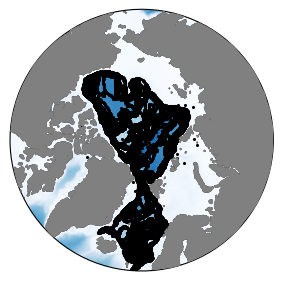

In [6]:
fig, ax = create_map(get_region_coords("arctic_ocean"),
                     figsize=set_size(width="AGU")
                    )
levels = np.arange(0, 5850, 250)
cmap = plt.get_cmap("Blues")
"""
c = ax.contourf(ds.lon, ds.lat, ds.depth,
                transform=ccrs.PlateCarree(),
                levels=levels,
                #levels=np.linspace(10, 600, 15),
                cmap=cmap
               )
"""

c = ax.pcolormesh(ds.lon, ds.lat, ds.depth,
                  transform=ccrs.PlateCarree(),
                  vmin=0,
                  vmax=5600,
                  cmap=cmap
                 )

for region_name in region_contours:
    contour_depths = region_contours[region_name]
    for contour_depth in contour_depths:
        contour = xr.open_dataset(datadir + region_name + "/contour_eff_" + str(contour_depth) + ".nc")
        ds_interp = ds.interp(x=contour.x, y=contour.y)
        ax.scatter(x=ds_interp.lon, y=ds_interp.lat,
                   c="black",
                   #alpha=1,
                   s=5,
                   linewidth=0,
                   transform=ccrs.PlateCarree()
                  )

                   
fig.savefig(figdir + f"geographical_context.png", dpi=300, bbox_inches="tight")

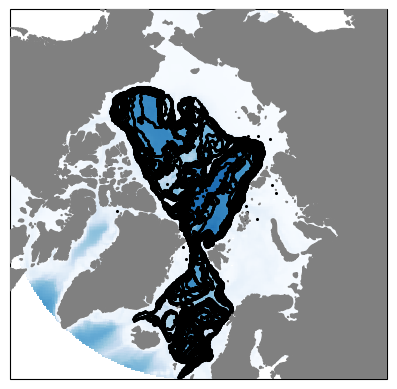

In [11]:
"""
fig, ax = create_map(get_region_coords("arctic_ocean"),
                     figsize=set_size(width="AGU")
                    )
"""
fig, ax = plt.subplots(1, 1,
                           #figsize=set_size(width="AGU"),
                           subplot_kw={"projection" : ccrs.Stereographic(central_latitude=90)}
                          )
levels = np.arange(0, 5850, 250)
cmap = plt.get_cmap("Blues")
"""
c = ax.contourf(ds.lon, ds.lat, ds.depth,
                transform=ccrs.PlateCarree(),
                levels=levels,
                #levels=np.linspace(10, 600, 15),
                cmap=cmap
               )
"""

c = ax.pcolormesh(ds.lon, ds.lat, ds.depth,
                  transform=ccrs.PlateCarree(),
                  vmin=0,
                  vmax=5600,
                  cmap=cmap
                 )
ax.add_feature(cfeature.LAND, color="grey", zorder=100)
ax.set_extent([-160, 160, 60, 90], crs=ccrs.PlateCarree())
for region_name in region_contours:
    contour_depths = region_contours[region_name]
    for contour_depth in contour_depths:
        contour = xr.open_dataset(datadir + region_name + "/contour_eff_" + str(contour_depth) + ".nc")
        ds_interp = ds.interp(x=contour.x, y=contour.y)
        ax.scatter(x=ds_interp.lon, y=ds_interp.lat,
                   c="black",
                   #alpha=1,
                   s=5,
                   linewidth=0,
                   transform=ccrs.PlateCarree()
                  )

                   
fig.savefig(figdir + f"geographical_context.png", dpi=300, bbox_inches="tight")